In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
class MemoryMappedGlucoseDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the root folder containing patient folders.
        """
        self.root_dir = root_dir
        self.patient_folders = sorted([
            f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))
        ])
    
    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        """
        Loads a patient's glucose.csv file using memory mapping.
        Returns:
            X: Torch tensor of glucose readings.
            y: Corresponding target labels (e.g., next glucose value or classification label).
        """
        patient_folder = self.patient_folders[idx]
        patient_glucose_path = os.path.join(self.root_dir, patient_folder, 'glucose.csv')

        if not os.path.exists(patient_glucose_path):
            raise FileNotFoundError(f"Missing file: {patient_glucose_path}")

        # Load glucose data with memory mapping
        glucose_df = pd.read_csv(patient_glucose_path, memory_map=True)
        
        # Convert to NumPy (assuming glucose values are in a column named 'glucose')
        X = glucose_df['glucose'].iloc[0:100].values  # All but last column
        y = glucose_df['glucose'].iloc[100:110].values   # Last column (e.g., target glucose levels)

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        return X_tensor, y_tensor

In [16]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class GlucoseTimeSeriesDataset(Dataset):
    def __init__(self, root_dir, seq_length=99, pred_length=10):
        self.root_dir = root_dir
        self.patient_folders = sorted([
            f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))
        ])
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        patient_folder = self.patient_folders[idx]
        patient_glucose_path = os.path.join(self.root_dir, patient_folder, 'glucose.csv')

        if not os.path.exists(patient_glucose_path):
            raise FileNotFoundError(f"Missing file: {patient_glucose_path}")

        # Load glucose data using memory mapping
        glucose_df = pd.read_csv(patient_glucose_path, memory_map=True)

        # Extract glucose values
        glucose_values = glucose_df.iloc[:, -1].values

        # Ensure enough data
        if len(glucose_values) < self.seq_length + self.pred_length:
            pad_size = (self.seq_length + self.pred_length) - len(glucose_values)
            glucose_values = list(glucose_values) + [0] * pad_size  # Pad with zeros

        # Sliding window for past 99 steps
        X = torch.tensor(glucose_values[:self.seq_length], dtype=torch.float32).unsqueeze(-1)  # Shape [99, 1]
        # Future values one step at a time
        y = torch.tensor(glucose_values[self.seq_length:self.seq_length + self.pred_length], dtype=torch.float32)

        return X, y


In [38]:
from torch.utils.data import Dataset, DataLoader, random_split

# Directory containing all patient subfolders
diabetes_dir = "/home/sncr0/data/d1namo/diabetes_subset_pictures-glucose-food-insulin/diabetes_subset_pictures-glucose-food-insulin"
# healthy_dir = "/home/sncr0/data/d1namo/healthy_subset_pictures-glucose-food/healthy_subset_pictures-glucose-food"
# Create dataset
dataset = MemoryMappedGlucoseDataset(diabetes_dir)
# healthy_dataset = MemoryMappedGlucoseDataset(healthy_dir)
# dataset = diabetes_dataset + healthy_dataset


train_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

# Example: Iterate through batches
for test_X_batch, test_y_batch in test_loader:
    print("Test Batch X shape:", test_X_batch.shape)
    print("Test Batch y shape:", test_y_batch.shape)
    break  # Remove this to loop through all batches

# Example: Iterate through batches
for train_X_batch, train_y_batch in train_loader:
    print("Train Batch X shape:", train_X_batch.shape)
    print("Train Batch y shape:", train_y_batch.shape)
    break  # Remove this to loop through all batches

Test Batch X shape: torch.Size([4, 100])
Test Batch y shape: torch.Size([4, 10])
Train Batch X shape: torch.Size([2, 100])
Train Batch y shape: torch.Size([2, 10])


In [39]:
import torch.nn as nn

class GlucoseLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2):
        super(GlucoseLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicts 1 step at a time

    def forward(self, x, future_steps=10):
        batch_size = x.size(0)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Hidden state
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Cell state

        predictions = []
        for _ in range(future_steps):
            # x : (batch_size, sequence_length, feature_dim)
            # lstm_out : (batch_size, sequence_length, hidden_dim)
            # h : (num_layers, batch_size, hidden_dim)
            # c : (num_layers, batch_size, hidden_dim)
            lstm_out, (h, c) = self.lstm(x, (h, c))  # Process input sequence

            next_value = self.fc(lstm_out[:, -1, :])  # Predict next step
            predictions.append(next_value.squeeze())

            # Use last prediction as new input (autoregressive step)
            x = torch.cat([x[:, 1:, :], next_value.unsqueeze(-1)], dim=1)

        return torch.stack(predictions, dim=1)  # Shape: (batch_size, future_steps)


In [40]:
# Initialize LSTM model
model = GlucoseLSTM()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensures correct shape: (batch_size, 100, 1)

        optimizer.zero_grad()
        y_pred = model(X_batch, future_steps=10)  # Predict 10 steps
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 26.1091
Epoch 2/50, Loss: 25.5375
Epoch 3/50, Loss: 24.9224
Epoch 4/50, Loss: 24.2067
Epoch 5/50, Loss: 23.3019
Epoch 6/50, Loss: 22.0602
Epoch 7/50, Loss: 20.2254
Epoch 8/50, Loss: 17.4050
Epoch 9/50, Loss: 13.3390
Epoch 10/50, Loss: 8.7684
Epoch 11/50, Loss: 5.1879
Epoch 12/50, Loss: 2.9671
Epoch 13/50, Loss: 1.6747
Epoch 14/50, Loss: 0.9505
Epoch 15/50, Loss: 0.6022
Epoch 16/50, Loss: 0.5146
Epoch 17/50, Loss: 0.5967
Epoch 18/50, Loss: 0.7557
Epoch 19/50, Loss: 0.9098
Epoch 20/50, Loss: 1.0172
Epoch 21/50, Loss: 1.0685
Epoch 22/50, Loss: 1.0703
Epoch 23/50, Loss: 1.0343
Epoch 24/50, Loss: 0.9725
Epoch 25/50, Loss: 0.8954
Epoch 26/50, Loss: 0.8123
Epoch 27/50, Loss: 0.7308
Epoch 28/50, Loss: 0.6574
Epoch 29/50, Loss: 0.5972
Epoch 30/50, Loss: 0.5535
Epoch 31/50, Loss: 0.5272
Epoch 32/50, Loss: 0.5175
Epoch 33/50, Loss: 0.5217
Epoch 34/50, Loss: 0.5354
Epoch 35/50, Loss: 0.5536
Epoch 36/50, Loss: 0.5712
Epoch 37/50, Loss: 0.5846
Epoch 38/50, Loss: 0.5916
Epoch 39/50,

In [41]:
# Switch to evaluation mode
model.eval()

# Get a sample batch
X_sample, y_sample = next(iter(test_loader))
X_sample = X_sample.unsqueeze(-1)  # Ensures correct shape: (batch_size, 100, 1)

y_pred_sample = model(X_sample)

# Print sample predictions
print("True y:", y_sample.tolist())
print("Predicted y:", y_pred_sample.tolist())

True y: [[2.4000000953674316, 2.299999952316284, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716], [8.800000190734863, 8.699999809265137, 8.600000381469727, 8.5, 8.5, 8.399999618530273, 8.399999618530273, 8.399999618530273, 8.399999618530273, 8.300000190734863], [9.699999809265137, 9.699999809265137, 9.5, 9.199999809265137, 8.899999618530273, 8.600000381469727, 8.600000381469727, 8.800000190734863, 9.199999809265137, 9.699999809265137], [10.0, 9.899999618530273, 9.699999809265137, 9.5, 9.300000190734863, 9.100000381469727, 8.800000190734863, 8.600000381469727, 8.399999618530273, 8.199999809265137]]
Predicted y: [[5.142253875732422, 5.142617225646973, 5.143192291259766, 5.143363952636719, 5.143425464630127, 5.143454074859619, 5.143470764160156, 5.143482208251953, 5.143489837646484, 5.143495082855225], [5.143659591674805, 5.144077301025391, 5.143667221069336, 5.143570899963379, 5.143546

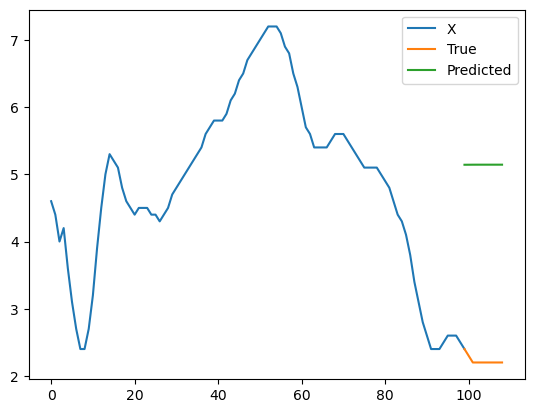

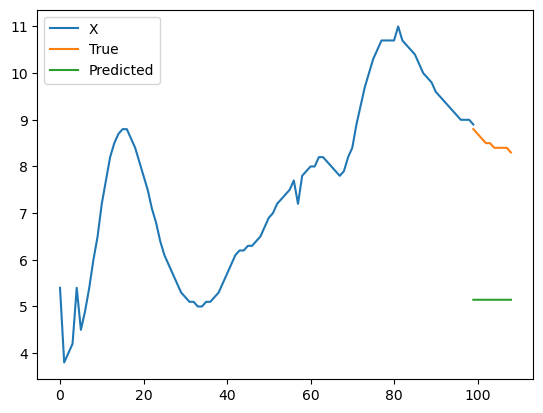

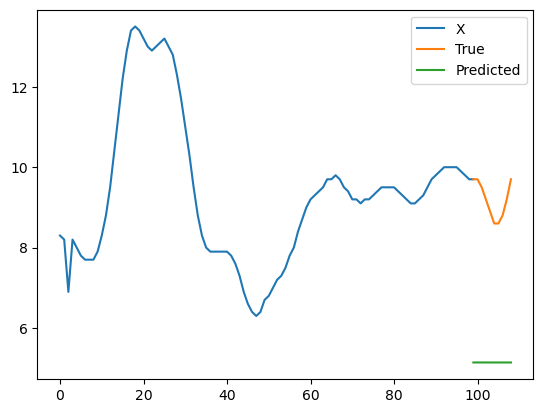

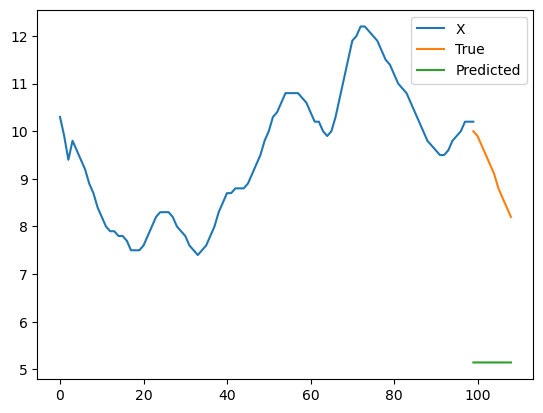

In [42]:
for y, y_pred, X in zip(y_sample, y_pred_sample, X_sample):
    plt.plot(X.detach().numpy(), label='X')
    plt.plot(np.linspace(99,108, 10), y.detach().numpy(), label='True')
    plt.plot(np.linspace(99,108, 10), y_pred.detach().numpy(), label='Predicted')
    plt.legend()
    plt.show()